# Name Gender Classifer
**Group:** *Justin Williams / Jacob Silver / Gregg Maloy*<br>

We will create a bunch of features, than use the `NavieBayesClassifier` from the **nltk** package to create the best name gender classifier we can.

**Stipulations are as follows:**<br>
Begin by splitting the Names Corpus into three subsets:
- 500 words for the test set
- 500 words for the devtest set
- remaining 6900 words for the training set.

Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

*How does the performance on the test set compare to the performance on the dev-test set?*<br>
*Is this what you'd expect?*

In [2]:
# import packages
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import names
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

## Import data
First step is to import the built in data from the **nltk** package.

In [3]:
# get words from corpus
male_words = nltk.corpus.names.words('male.txt')
female_words = nltk.corpus.names.words('female.txt')

# create list of tuples
names = [(name, 'male') for name in male_words] + [(name, 'female') for name in female_words]

names[:10]

[('Aamir', 'male'),
 ('Aaron', 'male'),
 ('Abbey', 'male'),
 ('Abbie', 'male'),
 ('Abbot', 'male'),
 ('Abbott', 'male'),
 ('Abby', 'male'),
 ('Abdel', 'male'),
 ('Abdul', 'male'),
 ('Abdulkarim', 'male')]

We can see this is a list made of tuples with a `name` and `gender`.


In [4]:
records=len(names)
print(f"There are {records} names in the list.")

There are 7944 names in the list.


## Create dataframe
We want to create a dataframe for easier feature creation and data exploration.

In [5]:
# create df
df = pd.DataFrame(list(names), columns=['name','gender'])

# preview
df.head()

,name,gender
0,Aamir,male
1,Aaron,male
2,Abbey,male
3,Abbie,male
4,Abbot,male


Let's verify df information.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7944 entries, 0 to 7943
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    7944 non-null   object
 1   gender  7944 non-null   object
dtypes: object(2)
memory usage: 124.3+ KB


We have **7944** rows, both columms are objects. <br>
Let's see if the dataset is balanced, by viewing the **male**/**female** counts in the target or `gender` column.

In [7]:
df.groupby('gender').size()

gender
female    5001
male      2943
dtype: int64

Here we can see that the dataset is primarily female.<br>
Let's look at this as a percentage.

In [8]:
# create groupby df
df_groupby = pd.DataFrame(df.groupby('gender').size()).reset_index().\
  rename(columns={0:'count'})

# create percentage col
df_groupby['perc'] = df_groupby['count'] / sum(df_groupby['count'])

In [9]:
df_groupby

,gender,count,perc
0,female,5001,0.629532
1,male,2943,0.370468


So almost 60/40 **female** to **male**.<br>
Let's visualize this.

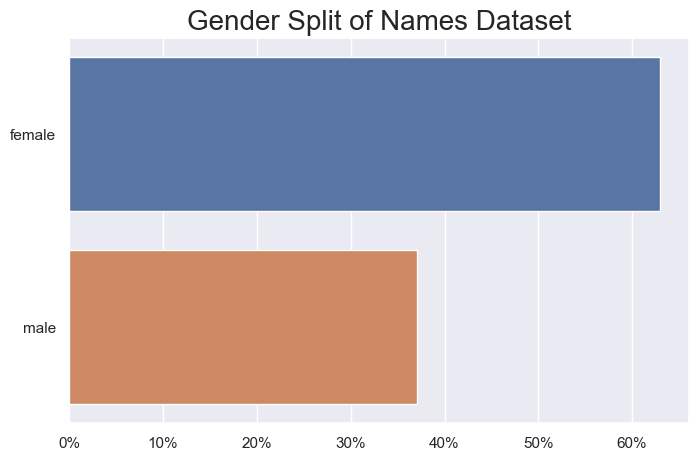

In [10]:
plt.figure(figsize=(8,5))
sns.set_theme("notebook")
sns.barplot(data=df_groupby,
            x='perc',
            y='gender')
plt.gca().xaxis.set_major_formatter('{:.0%}'.format)
plt.xlabel('')
plt.ylabel('')
plt.title('Gender Split of Names Dataset', fontdict={'size':20})
plt.show()

Ideally prior to building a classifier we would want to deal with balancing the dataset. Let's oversample the minority class.

### Oversample minority class


In [11]:
# split on gender
male_df = df[df['gender'] == 'male']
female_df = df[df['gender'] == 'female']

# over sample male
upsampled_male_df = resample(male_df, replace=True, 
                             n_samples=len(female_df), 
                             random_state=42)

# combine the upsampled male samples with the original female samples
df = pd.concat([upsampled_male_df, female_df])

In [12]:
df.groupby('gender').size()

gender
female    5001
male      5001
dtype: int64

Now we have a balanced dataset.

## Feature creation
Let's create some features that could be relevant to classifying names.

We will try the following:
- Name length
- Suffix
  - 1, 2 and 3 
- Prefix
  - 1, 2 and 3
- Vowels
  - Count
  - Ratio
  - Consecutive
- Consonant
  - Count
  - Ratio
  - Consecutive


In [13]:
# function to create name length
def name_length_col(df, col):
    """
    Takes in df and col, creates new col with length of value
    """
    df['name_length'] = [len(col) for col in df[col]]

# function to create columns with suffix
def suffix_col(df, col):
    """
    Takes in df and col, creates columns for suffix
    """
    suffix_name_list = ['suffix_one','suffix_two','suffix_three']
    index_list = [-1,-2,-3]
    for name, idx in zip(suffix_name_list, index_list):
        df[name] = [val[idx:] if len(val) >= abs(idx) else '' for val in df[col]]

# function to create columns with prefix
def prefix_col(df, col):
    """
    Takes in df and col, creates prefix columns
    """
    prefix_name_list = ['prefix_one','prefix_two','prefix_three']
    index_list = [1,2,3]
    for name, idx in zip(prefix_name_list, index_list):
        df[name] = [val[:idx].lower() if len(val) >= abs(idx) else '' for val in df[col]]

# function for vowels
def vowels_col(df, col):
    """
    Takes in df and col, creates features based on vowels
    """
    df['vowel_count'] = [sum(char.lower() in 'aeiou' for char in name) for name in df[col]]
    df['vowel_ratio'] = df['vowel_count'] / len(df[col])
    df['vowel_consecutive'] = [max([len(match) for match in re.findall \
                                   (r'[aeiou]+', name.lower())] or [0]) for name in df[col]]
    
# function for consonants
def consonants_col(df, col):
    """
    Takes in df and col, creates features based on consonants
    """
    df['consonant_count'] = [sum(char.lower() in 'bcdfghjklmnpqrstvwxyz' \
                                 for char in name) for name in df[col]]
    df['consonant_ratio'] = df['consonant_count'] / len(df[col])
    df['consonant_consecutive'] = [max([len(match) for match in re.findall \
                                       (r'[bcdfghjklmnpqrstvwxyz]+', name.lower())] or [0]) \
                                        for name in df[col]]

    

Ok, now let's apply these feature creation functions to the dataframe.

In [14]:
# apply to df
name_length_col(df,'name')
suffix_col(df,'name')
prefix_col(df, 'name')
vowels_col(df,'name')
consonants_col(df,'name')

In [15]:
# preview
df.head()

,name,gender,name_length,suffix_one,suffix_two,suffix_three,prefix_one,prefix_two,prefix_three,vowel_count,vowel_ratio,vowel_consecutive,consonant_count,consonant_ratio,consonant_consecutive
860,Forbes,male,6,s,es,bes,f,fo,for,2,0.0002,1,4,0.0004,2
1294,Jean-Francois,male,13,s,is,ois,j,je,jea,5,0.0005,2,7,0.0007,2
1130,Hazel,male,5,l,el,zel,h,ha,haz,2,0.0002,1,3,0.0003,1
1095,Harald,male,6,d,ld,ald,h,ha,har,2,0.0002,1,4,0.0004,2
1638,Marmaduke,male,9,e,ke,uke,m,ma,mar,4,0.0004,1,5,0.0005,2


## Modeling
### Split dataset
Next we need to split the dataset into `train`, `test`, and `devtest`.
However since we over sampled we will do approximately the following:
- 1000 words for the test set
- 1000 words for the devtest set
- remaining ~8000 words for the training set.


In [16]:
# split dataset into train and remaining 0.1258
train_df, remaining_df = train_test_split(df, test_size=0.2, random_state=42)
# further split the remaing data into devtest and test sets
devtest_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)


Next I would like to check if there are any overlap between sets.

In [19]:

# check if there is any overlap between the sets
overlap_train_devtest = set(train_df['name']).intersection(devtest_df['name'])
overlap_train_test = set(train_df['name']).intersection(test_df['name'])
overlap_devtest_test = set(devtest_df['name']).intersection(test_df['name'])

if overlap_train_devtest or overlap_train_test or overlap_devtest_test:
    print("There is overlap between the sets.")
else:
    print("There is no overlap between the sets.")

There is overlap between the sets.


It looks like there are, this is because we oversampled the minority class. However it is also because some names are considered gender neutral appear both defined as `male` and `female` within the datset.<br>
Would perhaps make sense to have a 3rd classification with `neutral` as the gender. But we we will be working with the `NaiveBayesClassifier` which only deals with a binary target, so I will not alter the original dataset.

In [391]:
df[df['name'] == 'Stacy']

,name,gender,name_length,suffix_one,suffix_two,suffix_three,prefix_one,prefix_two,prefix_three,vowel_count,vowel_ratio,vowel_consecutive,consonant_count,consonant_ratio,consonant_consecutive
2424,Stacy,male,5,y,cy,acy,s,st,sta,1,0.0001,1,4,0.0004,2
2424,Stacy,male,5,y,cy,acy,s,st,sta,1,0.0001,1,4,0.0004,2
7447,Stacy,female,5,y,cy,acy,s,st,sta,1,0.0001,1,4,0.0004,2


### Feature extraction
Since we are using **nltk** built-in classifer, we need to extract the features from the dataframe as a list of tuples.

In [422]:
# feature extraction function
def extract_features(row):
    columns = ['name','name_length', 'suffix_one', 'suffix_two','suffix_three', 'prefix_one', 
               'prefix_two', 'prefix_three','vowel_count', 'vowel_ratio', 'vowel_consecutive', 
               'consonant_count','consonant_ratio', 'consonant_consecutive']
    features = {}
    for col in columns:
        features[col] = row[col]
    return features, row['gender']

In [423]:
# apply function to each df
train_features = train_df.apply(extract_features, axis=1).to_list()
devtest_features = devtest_df.apply(extract_features, axis=1).to_list()
test_features = test_df.apply(extract_features, axis=1).to_list()

### Train model 
Next we can train the model on on training set, and run it on devtest set.

In [424]:
# train model on training set
nb_classifier = nltk.NaiveBayesClassifier.train(train_features)

In [431]:
# check accuracy
print(nltk.classify.accuracy(nb_classifier, devtest_features))

0.858


Accuracy of 85% is pretty high, much higher than the accuracy level in the book.<br>
Let's see if we can pinpoint what some of the errors were.

### Error Analysis
Look at some of the errors in devtest set.

In [433]:
errors = []
for featureset, tag in devtest_features[:150]:
    guess = nb_classifier.classify(featureset)
    if guess != tag:
        name = featureset['name']
        errors.append((tag, guess, name))

# Print the errors
for tag, guess, name in errors:
    print(f"Expected: {tag}, Predicted: {guess}, Name: {name}")

Expected: female, Predicted: male, Name: Star
Expected: male, Predicted: female, Name: Nate
Expected: male, Predicted: female, Name: Samuele
Expected: female, Predicted: male, Name: Margaret
Expected: male, Predicted: female, Name: Darryl
Expected: female, Predicted: male, Name: Ninon
Expected: male, Predicted: female, Name: Isidore
Expected: female, Predicted: male, Name: Dian
Expected: male, Predicted: female, Name: Jaime
Expected: female, Predicted: male, Name: Sinead
Expected: male, Predicted: female, Name: Lonnie
Expected: female, Predicted: male, Name: Angel
Expected: female, Predicted: male, Name: Consuelo
Expected: female, Predicted: male, Name: Freddie
Expected: female, Predicted: male, Name: Kerrill
Expected: female, Predicted: male, Name: Clarey
Expected: female, Predicted: male, Name: Easter
Expected: male, Predicted: female, Name: Maxie
Expected: female, Predicted: male, Name: Chris
Expected: male, Predicted: female, Name: Ali
Expected: female, Predicted: male, Name: Halei

Some of these are obvious mistakes i.e. Pete would typically be male, whereas Margaret would be female. <br>
Some of these should be in the `gender netural` category such as Angel and Chris.
So we can see there is room for improvement in this model.<br>

Some of the features here that jump out to me to be added could be:
- creating a `bool` column for:
  - ending in `eigh` for female (reaction to Haleigh being predicted as male)
  - ending in `fy` for female (reaction to Tiffy being predicted as male)

However, if we are were to adjust features, then each time the error analysis procedure is repeated, we should select a different devtest/training split, otherwise the the classifier could start to reflect idiosyncrasies in the devtest set. 

Let's see how it performs on the test set.

In [435]:
# run on test set
print(nltk.classify.accuracy(nb_classifier, test_features))

0.8581418581418582


Pretty much the same score as the devtest set. I am not surprised, because I think oversampling the minority class creates a less volitle model. 

## Conclusion
This is just the tip of the iceberg with name classification, however we have a few important takeaways. 
- Some names are gender neutral, therefore are repeated in the dataset with different target outcomes.
- Perhaps make sense to have a 3rd classification for `gender netural` names, however this would require utilizing a classifier that can work with a non-binary target.
- Some names alternate spelling increase ambiguity i.e. Samuele which is male, but was identified by the classifier as female.
- Additional features added after error analysis need to be coupled with re-splitting of dataset, otherwise model will overfit to devtest set.
- Balancing the dataset creates a more consistently reliable model.